In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_3080.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_3357.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_0983.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_1124.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_3829.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_3515.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_1324.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_4162.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_scc_0771.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_scc_0707.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_scc_3093.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_0952.jpg
/kaggle/input

In [2]:
# Install dependencies
!pip install -q lightly tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 16.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [11]:
import torch
import torchvision
from torch import nn
import os
import copy
from tqdm import tqdm
from torch.cuda.amp import autocast
from torch.amp import GradScaler
from PIL import Image

# Import from lightly
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimSiamPredictionHead, SimSiamProjectionHead
from lightly.transforms import SimSiamTransform
from lightly.data import LightlyDataset

# Import for evaluation
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms
from sklearn.metrics import classification_report, accuracy_score


In [4]:
# Set environment variable to help with memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [5]:
# =============================================================================
# STEP 1: MODEL DEFINITION
# =============================================================================
class SimSiam(nn.Module):
    def __init__(self, backbone, backbone_out_dim):
        super().__init__()
        self.backbone = backbone
        # Adjust projection head to match the backbone's output dimension
        self.projection_head = SimSiamProjectionHead(backbone_out_dim, 2048, 2048)
        self.prediction_head = SimSiamPredictionHead(2048, 512, 2048)

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(f)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p

# =============================================================================
# STEP 2: SELF-SUPERVISED PRE-TRAINING
# =============================================================================
print("--- Starting Part 1: Self-Supervised Pre-training ---")

--- Starting Part 1: Self-Supervised Pre-training ---


In [6]:
# --- Configuration ---
BACKBONE_OUT_DIM = 2048 # Output features from ResNet-50
BATCH_SIZE = 64
EPOCHS = 100 # You can adjust this; 100 is a good starting point
LEARNING_RATE = 0.06
NUM_WORKERS = os.cpu_count()
device = "cuda" if torch.cuda.is_available() else "cpu"
input_dir = "/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/"

In [7]:
# --- Model Setup ---
resnet = torchvision.models.resnet50()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = SimSiam(backbone, BACKBONE_OUT_DIM)

In [8]:
# Use DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model.to(device)

Using 2 GPUs!


DataParallel(
  (module): SimSiam(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
     

In [9]:
# --- Data Setup ---
transform = SimSiamTransform(input_size=224, vf_prob=0.5, hf_prob=0.5, rr_prob=0.5)
dataset = LightlyDataset(input_dir=input_dir, transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [12]:
# --- Optimizer, Loss, and Scaler ---
criterion = NegativeCosineSimilarity()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
scaler = GradScaler()

In [13]:
# --- Training Loop ---
print("Starting SimSiam Training")
for epoch in range(EPOCHS):
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for (x0, x1), _, _ in progress_bar:
        x0 = x0.to(device)
        x1 = x1.to(device)
        
        optimizer.zero_grad()
        
        with autocast():
            z0, p0 = model(x0)
            z1, p1 = model(x1)
            loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.detach().item()
        progress_bar.set_postfix({"loss": f"{loss.detach().item():.5f}"})

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch: {epoch+1:>02}, Avg Loss: {avg_loss:.5f}")

Starting SimSiam Training


Epoch 1/100:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipykernel_36/38859699.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/100: 100%|██████████| 156/156 [01:51<00:00,  1.40it/s, loss=-0.81272]


Epoch: 01, Avg Loss: -0.61918


Epoch 2/100: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s, loss=-0.83832]


Epoch: 02, Avg Loss: -0.83774


Epoch 3/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.83459]


Epoch: 03, Avg Loss: -0.84865


Epoch 4/100: 100%|██████████| 156/156 [01:45<00:00,  1.47it/s, loss=-0.81757]


Epoch: 04, Avg Loss: -0.84561


Epoch 5/100: 100%|██████████| 156/156 [01:45<00:00,  1.47it/s, loss=-0.50957]


Epoch: 05, Avg Loss: -0.69429


Epoch 6/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.79294]


Epoch: 06, Avg Loss: -0.62907


Epoch 7/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.77794]


Epoch: 07, Avg Loss: -0.69591


Epoch 8/100: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s, loss=-0.74323]


Epoch: 08, Avg Loss: -0.69389


Epoch 9/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.79163]


Epoch: 09, Avg Loss: -0.72967


Epoch 10/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.80284]


Epoch: 10, Avg Loss: -0.72850


Epoch 11/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.77848]


Epoch: 11, Avg Loss: -0.73357


Epoch 12/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.68429]


Epoch: 12, Avg Loss: -0.76551


Epoch 13/100: 100%|██████████| 156/156 [01:44<00:00,  1.50it/s, loss=-0.75527]


Epoch: 13, Avg Loss: -0.65984


Epoch 14/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.79274]


Epoch: 14, Avg Loss: -0.67341


Epoch 15/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.61747]


Epoch: 15, Avg Loss: -0.71380


Epoch 16/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.72606]


Epoch: 16, Avg Loss: -0.70585


Epoch 17/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.65896]


Epoch: 17, Avg Loss: -0.65788


Epoch 18/100: 100%|██████████| 156/156 [01:45<00:00,  1.49it/s, loss=-0.54327]


Epoch: 18, Avg Loss: -0.61080


Epoch 19/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.76154]


Epoch: 19, Avg Loss: -0.67290


Epoch 20/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.66915]


Epoch: 20, Avg Loss: -0.66083


Epoch 21/100: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s, loss=-0.62227]


Epoch: 21, Avg Loss: -0.63214


Epoch 22/100: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s, loss=-0.59258]


Epoch: 22, Avg Loss: -0.66839


Epoch 23/100: 100%|██████████| 156/156 [01:45<00:00,  1.47it/s, loss=-0.70745]


Epoch: 23, Avg Loss: -0.72354


Epoch 24/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.74579]


Epoch: 24, Avg Loss: -0.75885


Epoch 25/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.82314]


Epoch: 25, Avg Loss: -0.77371


Epoch 26/100: 100%|██████████| 156/156 [01:45<00:00,  1.47it/s, loss=-0.74471]


Epoch: 26, Avg Loss: -0.78063


Epoch 27/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.83220]


Epoch: 27, Avg Loss: -0.78086


Epoch 28/100: 100%|██████████| 156/156 [01:44<00:00,  1.50it/s, loss=-0.77169]


Epoch: 28, Avg Loss: -0.79500


Epoch 29/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.81087]


Epoch: 29, Avg Loss: -0.81743


Epoch 30/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.86062]


Epoch: 30, Avg Loss: -0.82402


Epoch 31/100: 100%|██████████| 156/156 [01:44<00:00,  1.50it/s, loss=-0.80307]


Epoch: 31, Avg Loss: -0.82612


Epoch 32/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.82455]


Epoch: 32, Avg Loss: -0.83193


Epoch 33/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.81207]


Epoch: 33, Avg Loss: -0.83779


Epoch 34/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.80474]


Epoch: 34, Avg Loss: -0.84267


Epoch 35/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.79803]


Epoch: 35, Avg Loss: -0.84405


Epoch 36/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.84781]


Epoch: 36, Avg Loss: -0.84417


Epoch 37/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.80811]


Epoch: 37, Avg Loss: -0.84083


Epoch 38/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.81810]


Epoch: 38, Avg Loss: -0.83701


Epoch 39/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.83207]


Epoch: 39, Avg Loss: -0.84180


Epoch 40/100: 100%|██████████| 156/156 [01:44<00:00,  1.50it/s, loss=-0.86800]


Epoch: 40, Avg Loss: -0.85144


Epoch 41/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.83315]


Epoch: 41, Avg Loss: -0.85397


Epoch 42/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.87182]


Epoch: 42, Avg Loss: -0.85984


Epoch 43/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.89130]


Epoch: 43, Avg Loss: -0.85866


Epoch 44/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.86892]


Epoch: 44, Avg Loss: -0.87326


Epoch 45/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.90639]


Epoch: 45, Avg Loss: -0.86413


Epoch 46/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.85508]


Epoch: 46, Avg Loss: -0.86532


Epoch 47/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.82516]


Epoch: 47, Avg Loss: -0.85681


Epoch 48/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.89259]


Epoch: 48, Avg Loss: -0.86183


Epoch 49/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.86936]


Epoch: 49, Avg Loss: -0.85962


Epoch 50/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.83353]


Epoch: 50, Avg Loss: -0.85616


Epoch 51/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.86605]


Epoch: 51, Avg Loss: -0.85321


Epoch 52/100: 100%|██████████| 156/156 [01:45<00:00,  1.47it/s, loss=-0.89091]


Epoch: 52, Avg Loss: -0.87090


Epoch 53/100: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s, loss=-0.86956]


Epoch: 53, Avg Loss: -0.86777


Epoch 54/100: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s, loss=-0.84812]


Epoch: 54, Avg Loss: -0.86957


Epoch 55/100: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s, loss=-0.86732]


Epoch: 55, Avg Loss: -0.87131


Epoch 56/100: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s, loss=-0.81238]


Epoch: 56, Avg Loss: -0.87570


Epoch 57/100: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s, loss=-0.89549]


Epoch: 57, Avg Loss: -0.87010


Epoch 58/100: 100%|██████████| 156/156 [01:45<00:00,  1.47it/s, loss=-0.79545]


Epoch: 58, Avg Loss: -0.85526


Epoch 59/100: 100%|██████████| 156/156 [01:45<00:00,  1.47it/s, loss=-0.91058]


Epoch: 59, Avg Loss: -0.86520


Epoch 60/100: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s, loss=-0.86105]


Epoch: 60, Avg Loss: -0.86599


Epoch 61/100: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s, loss=-0.84402]


Epoch: 61, Avg Loss: -0.87024


Epoch 62/100: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s, loss=-0.83932]


Epoch: 62, Avg Loss: -0.87030


Epoch 63/100: 100%|██████████| 156/156 [01:47<00:00,  1.46it/s, loss=-0.90479]


Epoch: 63, Avg Loss: -0.87846


Epoch 64/100: 100%|██████████| 156/156 [01:48<00:00,  1.44it/s, loss=-0.85587]


Epoch: 64, Avg Loss: -0.88310


Epoch 65/100: 100%|██████████| 156/156 [01:47<00:00,  1.45it/s, loss=-0.84395]


Epoch: 65, Avg Loss: -0.86592


Epoch 66/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.85066]


Epoch: 66, Avg Loss: -0.87018


Epoch 67/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.89776]


Epoch: 67, Avg Loss: -0.87131


Epoch 68/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.86964]


Epoch: 68, Avg Loss: -0.89189


Epoch 69/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.84984]


Epoch: 69, Avg Loss: -0.87997


Epoch 70/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.86856]


Epoch: 70, Avg Loss: -0.87478


Epoch 71/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.89534]


Epoch: 71, Avg Loss: -0.87378


Epoch 72/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.81910]


Epoch: 72, Avg Loss: -0.86901


Epoch 73/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.87179]


Epoch: 73, Avg Loss: -0.87896


Epoch 74/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.83929]


Epoch: 74, Avg Loss: -0.87501


Epoch 75/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.92718]


Epoch: 75, Avg Loss: -0.87690


Epoch 76/100: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s, loss=-0.88401]


Epoch: 76, Avg Loss: -0.88134


Epoch 77/100: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, loss=-0.89422]


Epoch: 77, Avg Loss: -0.87885


Epoch 78/100: 100%|██████████| 156/156 [01:44<00:00,  1.50it/s, loss=-0.87517]


Epoch: 78, Avg Loss: -0.88222


Epoch 79/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.87798]


Epoch: 79, Avg Loss: -0.87374


Epoch 80/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.86170]


Epoch: 80, Avg Loss: -0.88730


Epoch 81/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.87856]


Epoch: 81, Avg Loss: -0.87549


Epoch 82/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.90074]


Epoch: 82, Avg Loss: -0.87247


Epoch 83/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.88325]


Epoch: 83, Avg Loss: -0.88184


Epoch 84/100: 100%|██████████| 156/156 [01:44<00:00,  1.50it/s, loss=-0.89475]


Epoch: 84, Avg Loss: -0.88973


Epoch 85/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.88133]


Epoch: 85, Avg Loss: -0.86670


Epoch 86/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.91339]


Epoch: 86, Avg Loss: -0.88944


Epoch 87/100: 100%|██████████| 156/156 [01:45<00:00,  1.47it/s, loss=-0.88108]


Epoch: 87, Avg Loss: -0.89285


Epoch 88/100: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s, loss=-0.87337]


Epoch: 88, Avg Loss: -0.88654


Epoch 89/100: 100%|██████████| 156/156 [01:43<00:00,  1.50it/s, loss=-0.90352]


Epoch: 89, Avg Loss: -0.89001


Epoch 90/100: 100%|██████████| 156/156 [01:44<00:00,  1.50it/s, loss=-0.88476]


Epoch: 90, Avg Loss: -0.88121


Epoch 91/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.89379]


Epoch: 91, Avg Loss: -0.87264


Epoch 92/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.90092]


Epoch: 92, Avg Loss: -0.88371


Epoch 93/100: 100%|██████████| 156/156 [01:44<00:00,  1.50it/s, loss=-0.90479]


Epoch: 93, Avg Loss: -0.88728


Epoch 94/100: 100%|██████████| 156/156 [01:43<00:00,  1.50it/s, loss=-0.90366]


Epoch: 94, Avg Loss: -0.88756


Epoch 95/100: 100%|██████████| 156/156 [01:43<00:00,  1.51it/s, loss=-0.91956]


Epoch: 95, Avg Loss: -0.89260


Epoch 96/100: 100%|██████████| 156/156 [01:43<00:00,  1.50it/s, loss=-0.87456]


Epoch: 96, Avg Loss: -0.89880


Epoch 97/100: 100%|██████████| 156/156 [01:43<00:00,  1.51it/s, loss=-0.87417]


Epoch: 97, Avg Loss: -0.88371


Epoch 98/100: 100%|██████████| 156/156 [01:43<00:00,  1.51it/s, loss=-0.88078]


Epoch: 98, Avg Loss: -0.88703


Epoch 99/100: 100%|██████████| 156/156 [01:43<00:00,  1.51it/s, loss=-0.92585]


Epoch: 99, Avg Loss: -0.88291


Epoch 100/100: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, loss=-0.88820]

Epoch: 100, Avg Loss: -0.88210


In [14]:
# Extract the trained backbone
trained_backbone = model.module.backbone if isinstance(model, nn.DataParallel) else model.backbone

In [15]:
# =============================================================================
# STEP 3: LINEAR EVALUATION
# =============================================================================
print("\n--- Starting Part 2: Linear Evaluation ---")


--- Starting Part 2: Linear Evaluation ---


In [16]:
class OralCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.jpg')]
        self.classes = ['Non-Cancer', 'Cancer']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = 0 if 'normal' in os.path.basename(img_path) else 1
        if self.transform:
            image = self.transform(image)
        return image, label

In [17]:
# --- Data Setup for Evaluation ---
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
labeled_dataset = OralCancerDataset(root_dir=input_dir, transform=eval_transform)
train_size = int(0.8 * len(labeled_dataset))
test_size = len(labeled_dataset) - train_size
train_dataset, test_dataset = random_split(labeled_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [18]:
# --- Classifier Setup ---
class LinearClassifier(nn.Module):
    def __init__(self, input_dim=BACKBONE_OUT_DIM, num_classes=2):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

classifier = LinearClassifier().to(device)
optimizer_clf = torch.optim.Adam(classifier.parameters(), lr=0.001)
criterion_clf = nn.CrossEntropyLoss()

In [21]:
# --- Train and Validate Classifier ---
trained_backbone.eval()
for param in trained_backbone.parameters():
    param.requires_grad = False

print("Training and Validating the Linear Classifier...")
for epoch in range(100):
    # Training phase
    classifier.train()
    train_total_loss = 0
    train_correct = 0
    train_total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            features = trained_backbone(imgs).flatten(start_dim=1)
        
        logits = classifier(features)
        loss = criterion_clf(logits, labels)
        
        optimizer_clf.zero_grad()
        loss.backward()
        optimizer_clf.step()

        train_total_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_avg_loss = train_total_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total

    # Validation phase
    classifier.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            features = trained_backbone(imgs).flatten(start_dim=1)
            logits = classifier(features)
            _, predicted = torch.max(logits.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    
    print(f"Epoch: {epoch+1:>02} | Loss: {train_avg_loss:.5f} | Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")


Training and Validating the Linear Classifier...
Epoch: 01 | Loss: 0.54895 | Train Acc: 74.48% | Val Acc: 74.61%
Epoch: 02 | Loss: 0.52307 | Train Acc: 75.13% | Val Acc: 77.26%
Epoch: 03 | Loss: 0.50667 | Train Acc: 76.08% | Val Acc: 76.71%
Epoch: 04 | Loss: 0.49831 | Train Acc: 76.28% | Val Acc: 77.61%
Epoch: 05 | Loss: 0.49066 | Train Acc: 77.08% | Val Acc: 76.71%
Epoch: 06 | Loss: 0.48380 | Train Acc: 77.43% | Val Acc: 77.71%
Epoch: 07 | Loss: 0.48832 | Train Acc: 77.70% | Val Acc: 78.81%
Epoch: 08 | Loss: 0.47462 | Train Acc: 78.34% | Val Acc: 78.91%
Epoch: 09 | Loss: 0.47082 | Train Acc: 78.63% | Val Acc: 79.51%
Epoch: 10 | Loss: 0.46761 | Train Acc: 78.69% | Val Acc: 79.61%
Epoch: 11 | Loss: 0.47063 | Train Acc: 78.99% | Val Acc: 79.71%
Epoch: 12 | Loss: 0.46480 | Train Acc: 78.60% | Val Acc: 80.86%
Epoch: 13 | Loss: 0.46090 | Train Acc: 79.14% | Val Acc: 79.66%
Epoch: 14 | Loss: 0.45888 | Train Acc: 79.23% | Val Acc: 79.91%
Epoch: 15 | Loss: 0.45497 | Train Acc: 79.43% | Val Acc

In [22]:
# --- Final Evaluation on Test Set ---
print("\n--- Final Performance on Test Set ---")
all_preds, all_labels = [], []
classifier.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        features = trained_backbone(imgs).flatten(start_dim=1)
        logits = classifier(features)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

class_names = ['Non-Cancer', 'Cancer']
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print(f"Final Test Accuracy: {accuracy_score(all_labels, all_preds) * 100:.2f}%")


--- Final Performance on Test Set ---

Classification Report:
              precision    recall  f1-score   support

  Non-Cancer       0.82      0.84      0.83      1008
      Cancer       0.83      0.81      0.82       993

    accuracy                           0.82      2001
   macro avg       0.82      0.82      0.82      2001
weighted avg       0.82      0.82      0.82      2001

Final Test Accuracy: 82.31%


Extracting features from the test set...


Feature Extraction: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]



Running t-SNE... (this may take a minute or two)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2001 samples in 0.002s...
[t-SNE] Computed neighbors for 2001 samples in 0.490s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2001
[t-SNE] Computed conditional probabilities for sample 2000 / 2001
[t-SNE] Computed conditional probabilities for sample 2001 / 2001
[t-SNE] Mean sigma: 0.114531
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.447105
[t-SNE] KL divergence after 300 iterations: 1.395565
Plotting t-SNE results...


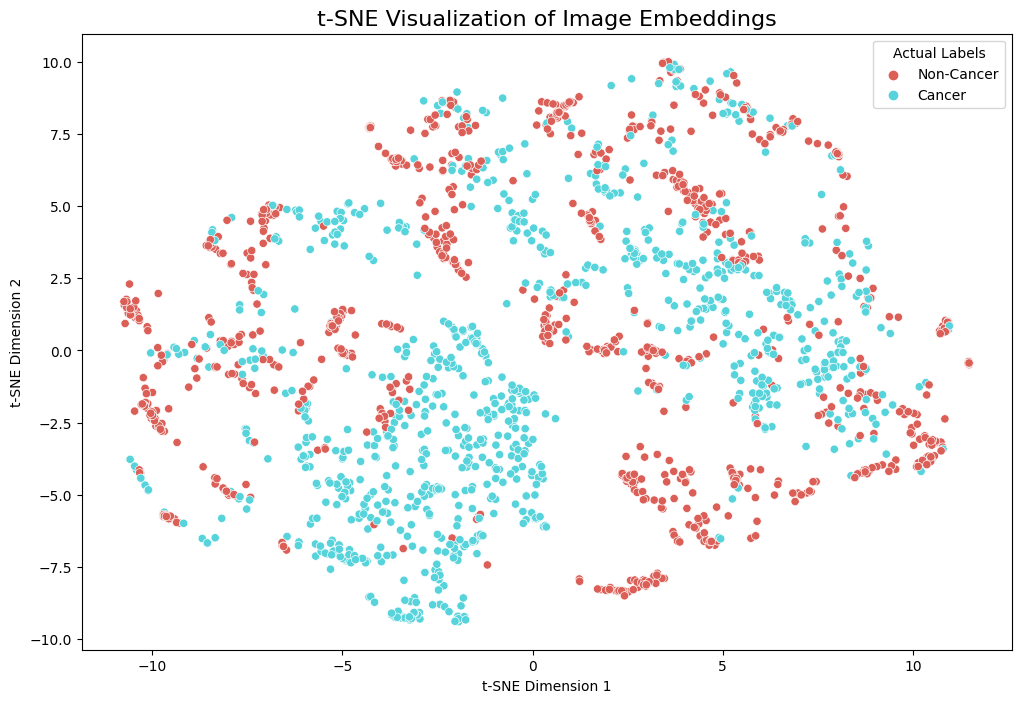


Running UMAP...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting UMAP results...


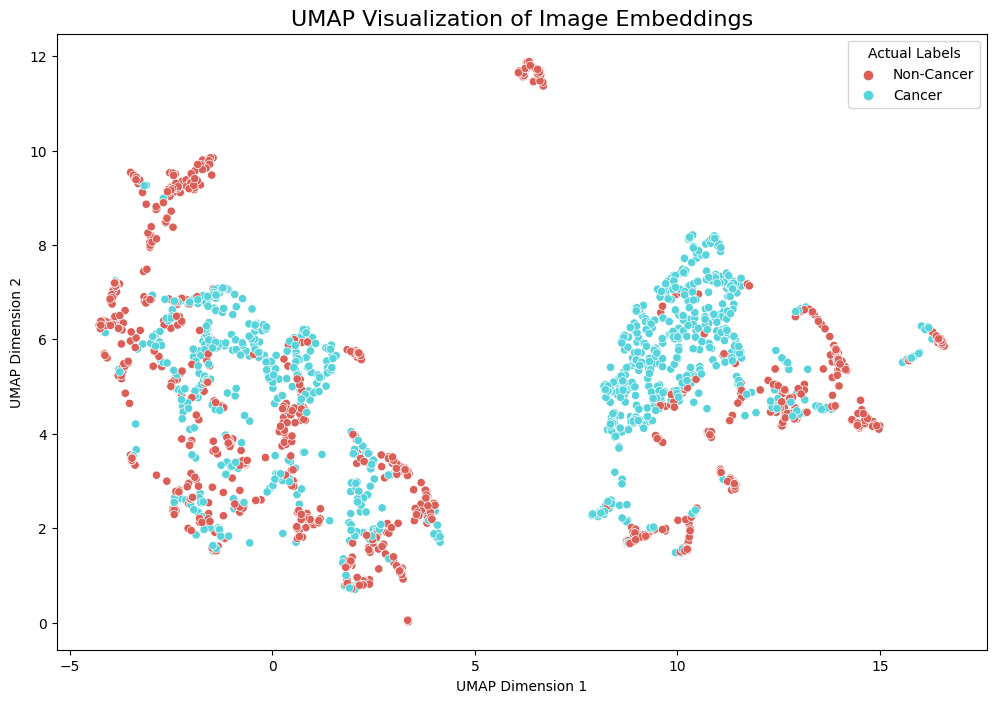

In [25]:
# =============================================================================
# STEP 4: VISUALIZING THE FEATURE SPACE
# =============================================================================
# First, ensure UMAP is installed
!pip install -q umap-learn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap # UMAP library

# --- 1. Get feature embeddings for the entire test set (if not already done) ---
print("Extracting features from the test set...")
classifier.eval()
trained_backbone.eval()
all_features = []
all_true_labels = []

# It's better to iterate through the test_loader without shuffling
test_loader_full = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

with torch.no_grad():
    for imgs, labels in tqdm(test_loader_full, desc="Feature Extraction"):
        imgs = imgs.to(device)
        features = trained_backbone(imgs).flatten(start_dim=1)
        all_features.append(features.cpu())
        all_true_labels.append(labels)

all_features = torch.cat(all_features).numpy()
all_true_labels = torch.cat(all_true_labels).numpy()
class_names = ['Non-Cancer', 'Cancer']

# --- 2. Apply and Plot t-SNE ---
print("\nRunning t-SNE... (this may take a minute or two)")
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(all_features)

print("Plotting t-SNE results...")
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=all_true_labels,
    palette=sns.color_palette("hls", 2),
    legend="full"
)
plt.title('t-SNE Visualization of Image Embeddings', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, class_names, title='Actual Labels')
plt.show()


# --- 3. Apply and Plot UMAP ---
print("\nRunning UMAP...")
reducer = umap.UMAP(random_state=42)
umap_results = reducer.fit_transform(all_features)

print("Plotting UMAP results...")
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=umap_results[:,0], y=umap_results[:,1],
    hue=all_true_labels,
    palette=sns.color_palette("hls", 2),
    legend="full"
)
plt.title('UMAP Visualization of Image Embeddings', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, class_names, title='Actual Labels')
plt.show()